<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%83%81%EC%B6%94%EC%9D%98_%EC%83%9D%EC%9C%A1_%ED%99%98%EA%B2%BD_%EC%83%9D%EC%84%B1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

상추의 생육 환경 생성 AI 경진대회

https://dacon.io/competitions/official/236033/overview/description

In [ ]:
!pip install catboost

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers

# data(cat)

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip'

In [250]:
train_01 = pd.read_csv('/content/train_input/CASE_01.csv')

In [182]:
train_01.columns

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

In [180]:
train_li = sorted(glob.glob('/content/train_input/*'))
test_li = sorted(glob.glob('/content/test_input/*'))

시간당 내부 평균온도: 4도~40도

시간당 내부 평균습도: 0% ~ 100%

시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm

시간당 평균 EC : 0 ~ 8

시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000

시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000

시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000 

시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000

시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000

In [183]:
for i in train_li + test_li:
    df = pd.read_csv(i)
    df['내부온도관측치'] = df['내부온도관측치'].clip(4,40)
    df['내부습도관측치'] = df['내부습도관측치'].clip(0,100)
    df['co2관측치']  = df['co2관측치'].clip(0,1200)
    df['ec관측치']  = df['ec관측치'].clip(0,8)
    df['시간당분무량']  = df['시간당분무량'].clip(0,3000)
    df['일간누적분무량']  = df['일간누적분무량'].clip(0,72000)
    df['시간당백색광량']  = df['시간당백색광량'].clip(0,120000)
    df['일간누적백색광량']  = df['일간누적백색광량'].clip(0,2880000)
    df['시간당적색광량']  = df['시간당적색광량'].clip(0,120000)
    df['일간누적적색광량']  = df['일간누적적색광량'].clip(0,2880000)
    df['시간당청색광량']  = df['시간당청색광량'].clip(0,120000)
    df['일간누적청색광량']  = df['일간누적청색광량'].clip(0,2880000)
    df['시간당총광량']  = df['시간당총광량'].clip(0,120000)
    df['일간누적총광량']  = df['일간누적총광량'].clip(0,2880000)
    df.to_csv(i, index=False)

In [187]:
li_mean = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량']
li_max = ['일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
# li_sum = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치']

In [189]:
def make_data(file):
    df = pd.read_csv(file)
    date = list(set(df['DAT'].values))
    case = {}

    for i in li_mean:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].mean())
        case[i] = va

    for i in li_max:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].max())
        case[i] = va

    # for i in li_sum:
    #     va = []
    #     for j in date:
    #         tt = df[df['DAT'] == j]
    #         va.append(tt[i].sum())
    #     case[i+' sum'] = va

    mdf = pd.DataFrame(case)
    return mdf

for i, j in enumerate(train_li):
    if i == 0:
        train_x = make_data(j)
    else:
        train_some = make_data(j)
        train_x = pd.concat([train_x, train_some], axis=0)
train_x.reset_index(drop=True, inplace=True)

for i, j in enumerate(test_li):
    if i == 0:
        test_x = make_data(j)
    else:
        test_some = make_data(j)
        test_x = pd.concat([test_x, test_some], axis=0)
test_x.reset_index(drop=True, inplace=True)
test_x

,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량,일간누적분무량,일간누적백색광량,일간누적적색광량,일간누적청색광량,일간누적총광량,내부온도관측치 sum,내부습도관측치 sum,co2관측치 sum,ec관측치 sum
0,27.489730,61.372104,465.722917,1.037389,510.255417,8728.198258,0.00000,0.000000,8728.198258,12246.13,209476.7582,0.0000,0.000,209476.7582,659.753530,1472.930508,11177.350000,24.897336
1,28.668803,63.148023,463.661311,1.034501,383.964167,8729.874229,0.00000,0.000000,8729.874229,9215.14,209516.9815,0.0000,0.000,209516.9815,688.051268,1515.552541,11127.871469,24.828015
2,28.407405,61.045223,488.883086,1.033113,496.323750,8734.386458,0.00000,0.000000,8734.386458,11911.77,209625.2750,0.0000,0.000,209625.2750,681.777709,1465.085341,11733.194068,24.794710
3,28.163750,64.356319,494.394444,1.033793,512.398750,8732.839408,0.00000,0.000000,8732.839408,12297.57,209588.1458,0.0000,0.000,209588.1458,675.930000,1544.551663,11865.466667,24.811042
4,27.302220,66.829097,528.349306,1.038796,369.764583,8734.515379,0.00000,0.000000,8734.515379,8874.35,209628.3691,0.0000,0.000,209628.3691,655.253275,1603.898332,12680.383333,24.931104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,25.884889,56.707123,460.703472,0.244860,133.285000,6111.878867,927.92910,436.270250,7476.078217,3198.84,146685.0928,22270.2984,10470.486,179425.8772,621.237343,1360.970960,11056.883333,5.876635
136,25.439344,56.979188,438.658477,0.912453,135.428333,6093.056425,924.68845,434.834292,7452.579167,3250.28,146233.3542,22192.5228,10436.023,178861.9000,610.544249,1367.500518,10527.803448,21.898880
137,25.041662,57.322359,443.938089,0.915924,113.892500,6110.331817,927.03275,435.878625,7473.243192,2733.42,146647.9636,22248.7860,10461.087,179357.8366,600.999883,1375.736610,10654.514124,21.982178
138,25.617847,57.048055,447.692361,0.918316,124.392500,6107.495558,927.23960,435.748083,7470.483242,2985.42,146579.8934,22253.7504,10457.954,179291.5978,614.828333,1369.153332,10744.616667,22.039573


In [190]:
train_ta = sorted(glob.glob('/content/train_target/*'))
for i, j in enumerate(train_ta):
    if i == 0:
        train_y = pd.read_csv(j)
    else:
        train_y_some = pd.read_csv(j)
        train_y = pd.concat([train_y, train_y_some], axis=0)
train_y.reset_index(drop=True, inplace=True)

In [191]:
test_ta = sorted(glob.glob('/content/test_target/*'))
for i, j in enumerate(test_ta):
    if i == 0:
        test_y = pd.read_csv(j)
    else:
        test_y_some = pd.read_csv(j)
        test_y = pd.concat([test_y, test_y_some], axis=0)
test_y.reset_index(drop=True, inplace=True)

In [192]:
train_all = pd.concat([train_x, train_y], axis=1)
test_all = pd.concat([test_x, test_y], axis=1)

In [193]:
test_x = test_all.copy()
test_y = test_x.pop('predicted_weight_g')

# cat

In [194]:
train_t = train_all[:-28]
train_v = train_all[-28:]

In [195]:
train_x = train_t.copy()
train_y = train_x.pop('predicted_weight_g')
val_x = train_v.copy()
val_y = val_x.pop('predicted_weight_g')

In [143]:
lr = LinearRegression()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
models = [lr, knr, rfr, xgb, lgbm, cat]
for i in models:
    model = i.fit(train_x, train_y)
    sc = round(model.score(train_x, train_y), 2)
    pre = model.predict(val_x)
    rmse = round(mean_squared_error(val_y, pre, squared=False), 2)
    print(f'model : {i.__class__.__name__}, sc : {sc}, rmse : {rmse}')

model : LinearRegression, sc : 0.68, rmse : 17.54
model : KNeighborsRegressor, sc : 0.61, rmse : 15.78
model : RandomForestRegressor, sc : 0.99, rmse : 4.34
[05:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model : XGBRegressor, sc : 0.98, rmse : 5.39
model : LGBMRegressor, sc : 1.0, rmse : 6.85
model : CatBoostRegressor, sc : 1.0, rmse : 4.05


In [196]:
lr = LinearRegression()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
models = [lr, knr, rfr, xgb, lgbm, cat]
for i in models:
    model = i.fit(train_x, train_y)
    sc = round(model.score(train_x, train_y), 2)
    pre = model.predict(val_x)
    rmse = round(mean_squared_error(val_y, pre, squared=False), 2)
    print(f'model : {i.__class__.__name__}, sc : {sc}, rmse : {rmse}')

model : LinearRegression, sc : 0.68, rmse : 17.54
model : KNeighborsRegressor, sc : 0.7, rmse : 18.33
model : RandomForestRegressor, sc : 0.99, rmse : 4.87
[07:15:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model : XGBRegressor, sc : 0.98, rmse : 5.39
model : LGBMRegressor, sc : 1.0, rmse : 6.85
model : CatBoostRegressor, sc : 1.0, rmse : 3.13


In [198]:
train_x = train_all.copy()
train_y = train_x.pop('predicted_weight_g')

In [199]:
cat = CatBoostRegressor(verbose=0)
model = cat.fit(train_x, train_y)
pre = model.predict(test_x)

#  data(CNN)

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip'
train_li = sorted(glob.glob('/content/train_input/*'))
test_li = sorted(glob.glob('/content/test_input/*'))
for i in train_li + test_li:
    df = pd.read_csv(i)
    df['내부온도관측치'] = df['내부온도관측치'].clip(4,40)
    df['내부습도관측치'] = df['내부습도관측치'].clip(0,100)
    df['co2관측치']  = df['co2관측치'].clip(0,1200)
    df['ec관측치']  = df['ec관측치'].clip(0,8)
    df['시간당분무량']  = df['시간당분무량'].clip(0,3000)
    df['일간누적분무량']  = df['일간누적분무량'].clip(0,72000)
    df['시간당백색광량']  = df['시간당백색광량'].clip(0,120000)
    df['일간누적백색광량']  = df['일간누적백색광량'].clip(0,2880000)
    df['시간당적색광량']  = df['시간당적색광량'].clip(0,120000)
    df['일간누적적색광량']  = df['일간누적적색광량'].clip(0,2880000)
    df['시간당청색광량']  = df['시간당청색광량'].clip(0,120000)
    df['일간누적청색광량']  = df['일간누적청색광량'].clip(0,2880000)
    df['시간당총광량']  = df['시간당총광량'].clip(0,120000)
    df['일간누적총광량']  = df['일간누적총광량'].clip(0,2880000)
    df['obs_time'] = df['obs_time'].str[:2].apply(int)
    df.to_csv(i, index=False)

In [265]:
for i, j in enumerate(train_li):
    if i == 0:
        train_x = pd.read_csv(j)
    else:
        train_x_some = pd.read_csv(j)
        train_x = pd.concat([train_x, train_x_some], axis=0)
train_x.reset_index(drop=True, inplace=True)       
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   obs_time  18816 non-null  int64  
 2   내부온도관측치   18816 non-null  float64
 3   내부습도관측치   18816 non-null  float64
 4   co2관측치    18816 non-null  float64
 5   ec관측치     18816 non-null  float64
 6   시간당분무량    18816 non-null  float64
 7   일간누적분무량   18816 non-null  float64
 8   시간당백색광량   18816 non-null  float64
 9   일간누적백색광량  18816 non-null  float64
 10  시간당적색광량   18816 non-null  float64
 11  일간누적적색광량  18816 non-null  float64
 12  시간당청색광량   18816 non-null  float64
 13  일간누적청색광량  18816 non-null  float64
 14  시간당총광량    18816 non-null  float64
 15  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(2)
memory usage: 2.3 MB


In [266]:
train_xx = train_x.copy()
_ = train_xx.pop('obs_time')

In [220]:
train_xx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   내부온도관측치   18816 non-null  float64
 2   내부습도관측치   18816 non-null  float64
 3   co2관측치    18816 non-null  float64
 4   ec관측치     18816 non-null  float64
 5   시간당분무량    18816 non-null  float64
 6   일간누적분무량   18816 non-null  float64
 7   시간당백색광량   18816 non-null  float64
 8   일간누적백색광량  18816 non-null  float64
 9   시간당적색광량   18816 non-null  float64
 10  일간누적적색광량  18816 non-null  float64
 11  시간당청색광량   18816 non-null  float64
 12  일간누적청색광량  18816 non-null  float64
 13  시간당총광량    18816 non-null  float64
 14  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 2.2 MB


In [243]:
train_xx.iloc[671]

DAT         1.000000
내부온도관측치     0.663009
내부습도관측치     0.883271
co2관측치      0.463511
ec관측치       0.000000
시간당분무량      0.000000
일간누적분무량     0.090783
시간당백색광량     0.000000
일간누적백색광량    0.874144
시간당적색광량     0.000000
일간누적적색광량    0.068069
시간당청색광량     0.000000
일간누적청색광량    0.000000
시간당총광량      0.000000
일간누적총광량     0.480645
Name: 671, dtype: float64

In [267]:
mms = MinMaxScaler()
for i in train_xx.columns:
    train_xx[i] = mms.fit_transform(train_xx[[i]])

In [268]:
train_image = train_xx.values.reshape(-1,24,15,1)
train_image.shape

(784, 24, 15, 1)

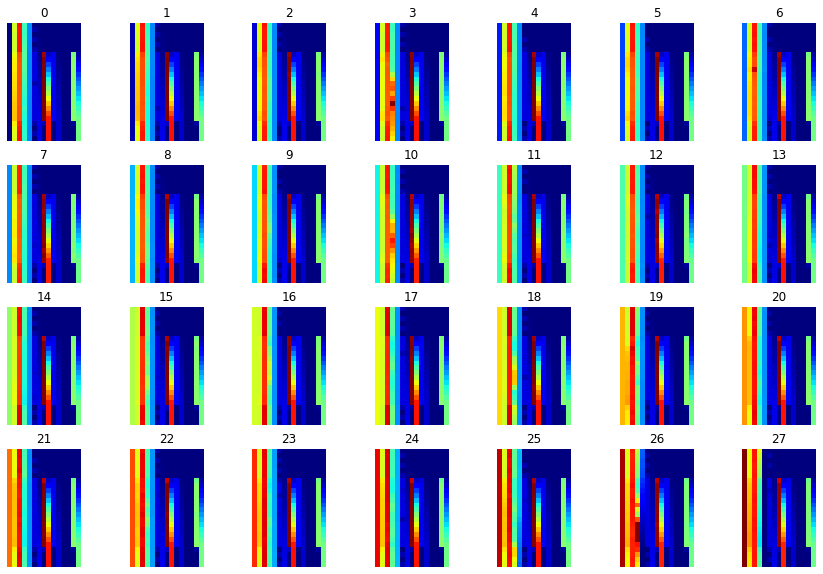

In [269]:
plt.figure(figsize=(15,10))
for i in range(28):
    plt.subplot(4,7,i+1)
    plt.title(i)
    plt.imshow(xx[i], cmap='jet')
    plt.axis(False)
plt.show()

In [261]:
train_ta = sorted(glob.glob('/content/train_target/*'))
for i, j in enumerate(train_ta):
    if i == 0:
        train_y = pd.read_csv(j)
    else:
        train_y_some = pd.read_csv(j)
        train_y = pd.concat([train_y, train_y_some], axis=0)
train_y.reset_index(drop=True, inplace=True)

In [262]:
train_y = train_y['predicted_weight_g']
train_y.shape

(784,)

# CNN

In [285]:
def make_model():
    inputs = layers.Input(shape=(24,15,1))
    x = layers.Conv2D(16,3,padding='same',activation='relu')(inputs)
    x = layers.Conv2D(16,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [286]:
model = make_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 15, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 15, 16)        160       
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 15, 16)        2320      
                                                                 
 batch_normalization_8 (Batc  (None, 24, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 15, 32)        4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 15, 32)        9248      
                                                           

In [287]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [288]:
his = model.fit(train_image, train_y, epochs=1000, validation_split=0.1)

Epoch 1/1000
23/23 [==============================] - 5s 188ms/step - loss: 2949.0574 - val_loss: 1270.0752
Epoch 2/1000
23/23 [==============================] - 4s 183ms/step - loss: 2000.9874 - val_loss: 1205.4904
Epoch 3/1000
23/23 [==============================] - 4s 181ms/step - loss: 851.0263 - val_loss: 1046.4998
Epoch 4/1000
23/23 [==============================] - 4s 181ms/step - loss: 410.4550 - val_loss: 1100.3896
Epoch 5/1000
23/23 [==============================] - 4s 181ms/step - loss: 310.3654 - val_loss: 1134.4653
Epoch 6/1000
 2/23 [=>............................] - ETA: 3s - loss: 217.7406

KeyboardInterrupt: ignored

# sub

In [200]:
!unzip '/content/sample_submission.zip'

Archive:  /content/sample_submission.zip
replace TEST_01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: TEST_01.csv             
  inflating: TEST_02.csv             
  inflating: TEST_03.csv             
  inflating: TEST_04.csv             
  inflating: TEST_05.csv             


In [201]:
test_01 = pd.read_csv('/content/TEST_01.csv')
test_01['predicted_weight_g'] = pre[:28]
test_01.to_csv('/content/TEST_01.csv', index=False)
test_02 = pd.read_csv('/content/TEST_02.csv')
test_02['predicted_weight_g'] = pre[28:56]
test_02.to_csv('/content/TEST_02.csv', index=False)
test_03 = pd.read_csv('/content/TEST_03.csv')
test_03['predicted_weight_g'] = pre[56:84]
test_03.to_csv('/content/TEST_03.csv', index=False)
test_04 = pd.read_csv('/content/TEST_04.csv')
test_04['predicted_weight_g'] = pre[84:112]
test_04.to_csv('/content/TEST_04.csv', index=False)
test_05 = pd.read_csv('/content/TEST_05.csv')
test_05['predicted_weight_g'] = pre[112:]
test_05.to_csv('/content/TEST_05.csv', index=False)